In [1]:
from numpy import mean, std
import seaborn as sns
import scipy
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import recall_score,balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix,average_precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import ConnectionPatch
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import  roc_curve, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from scipy.stats import mannwhitneyu
from xgboost import XGBClassifier
import shap
import numpy
import xgboost
from sklearnex import patch_sklearn 



In [2]:
df=pd.read_csv('data/df.csv',index_col=0)

In [3]:
X=df.iloc[:,:-1]
y=[]
for i in df.index:
    if df.loc[i,'Diagnosis']=='Normal':
        y.append(0)
    else:
        y.append(1)
y=np.array(y)

In [6]:
np.random.seed(1) # Reproducibility 
CV_repeats = 20
# Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
random_states = np.random.randint(10000, size=CV_repeats) 

######## Use a dict to track the SHAP values of each observation per CV repitition 

shap_values_per_cv = dict()
for sample in X.index:
    ## Create keys for each sample
    shap_values_per_cv[sample] = {} 
    ## Then, keys for each CV fold within each sample
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv[sample][CV_repeat] = {}
        


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)



------------ CV Repeat number: 0

------ Fold Number: 0
Best parameters of the model are:  {'gamma': 0.001, 'C': 10}

------ Fold Number: 1
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}

------ Fold Number: 2
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}

------ Fold Number: 3
Best parameters of the model are:  {'gamma': 0.001, 'C': 10}

------ Fold Number: 4
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------------ CV Repeat number: 1

------ Fold Number: 0
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------ Fold Number: 1
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------ Fold Number: 2
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------ Fold Number: 3
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------ Fold Number: 4
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------------ CV Repeat number: 2

------ Fold Number: 0
Best parameters of the model are:  {'gamma': 

Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------ Fold Number: 2
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}

------ Fold Number: 3
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}

------ Fold Number: 4
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------------ CV Repeat number: 19

------ Fold Number: 0
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}

------ Fold Number: 1
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------ Fold Number: 2
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------ Fold Number: 3
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}

------ Fold Number: 4
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}


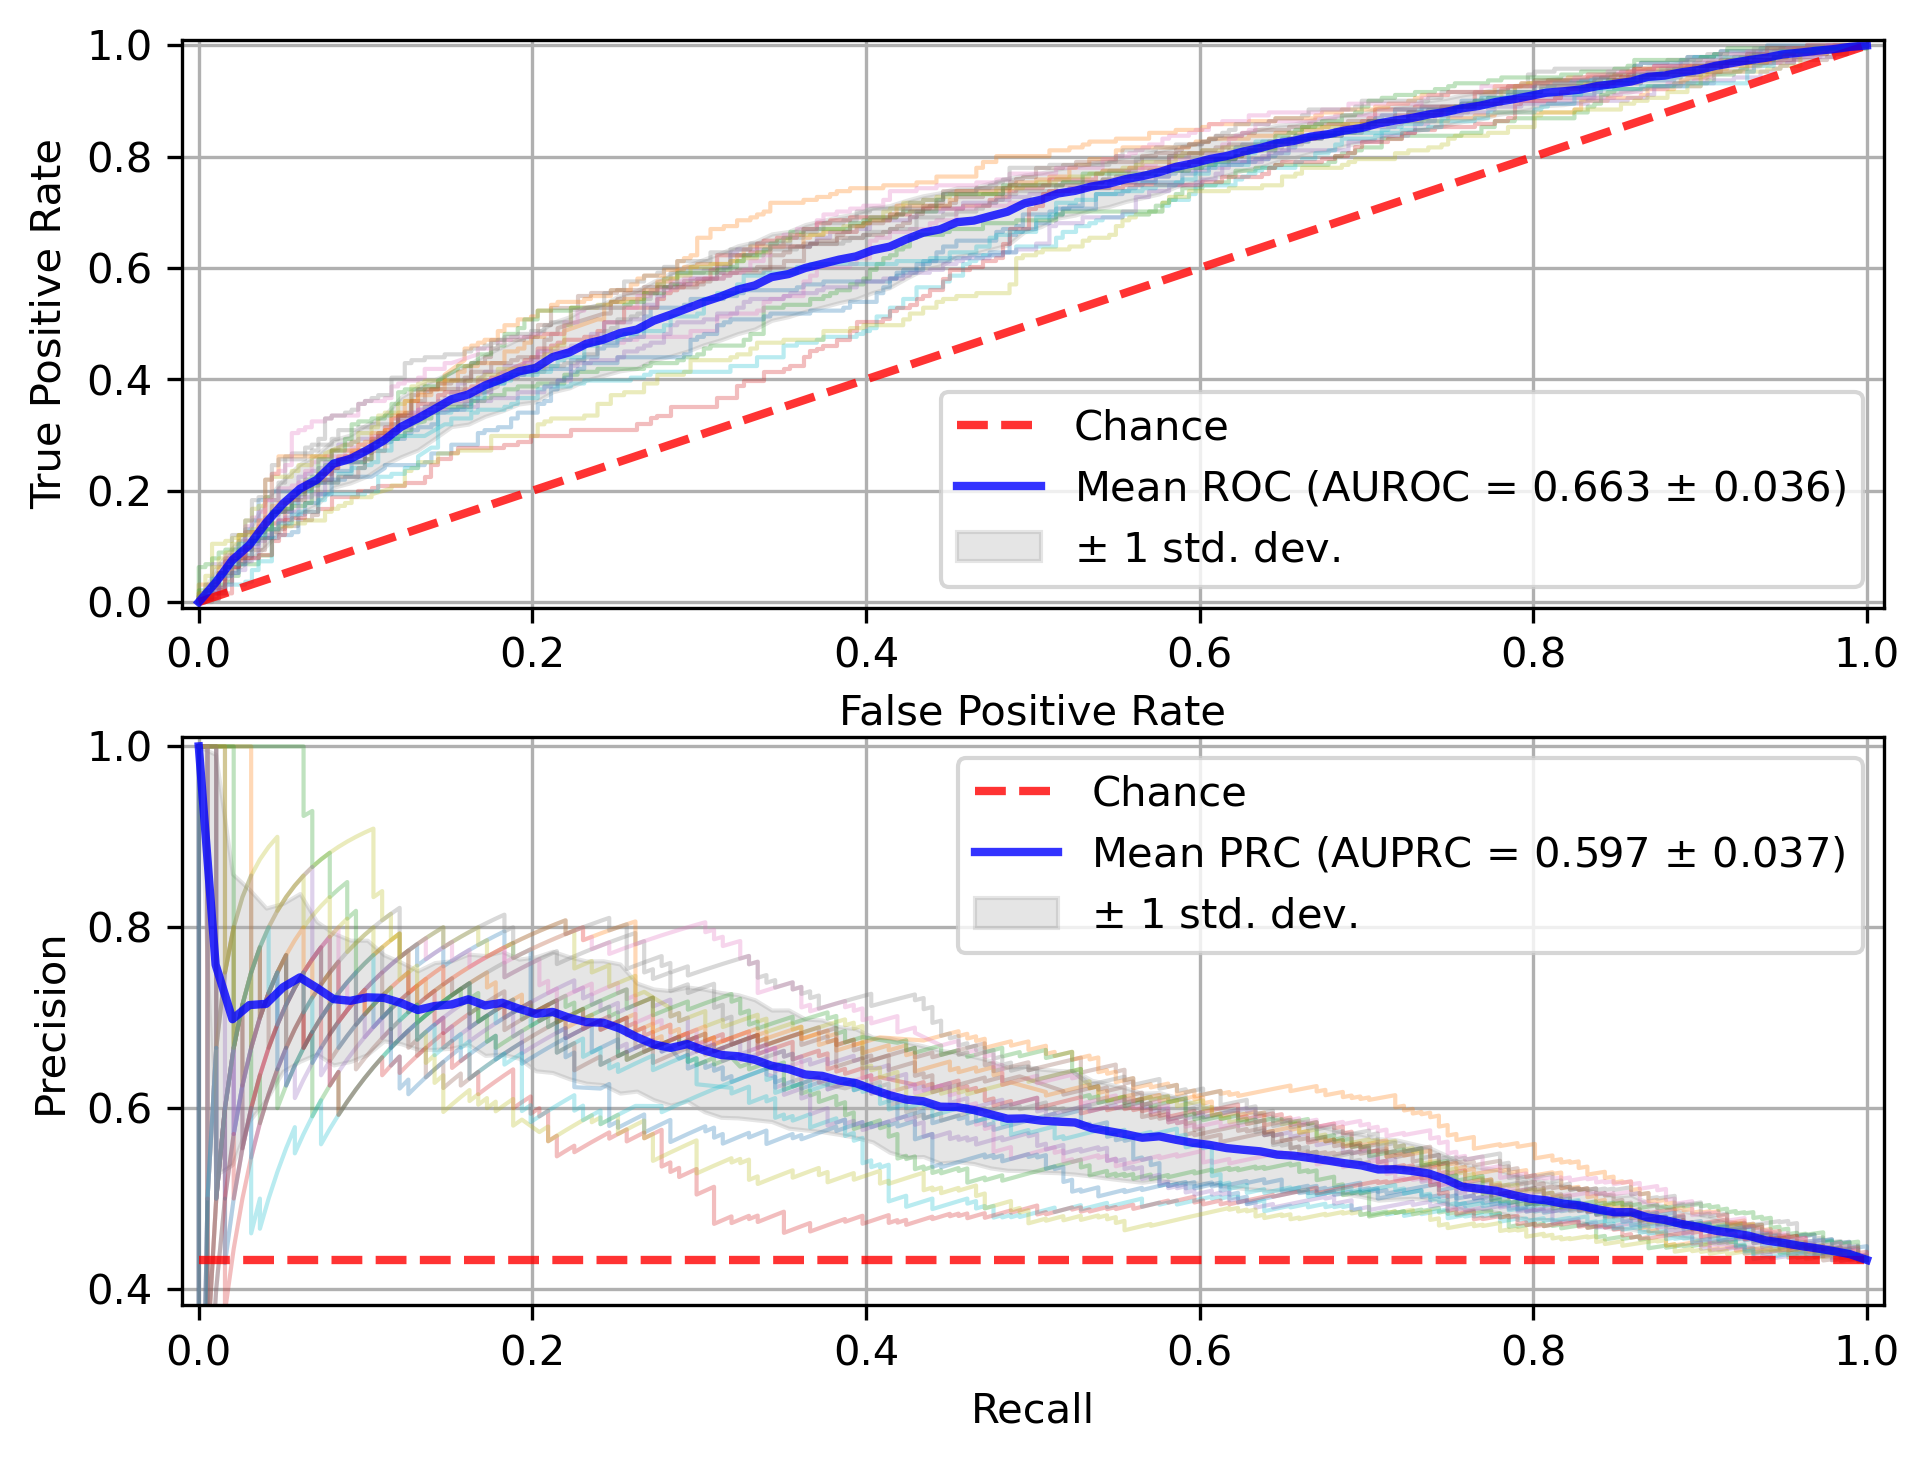

In [7]:
patch_sklearn()

fig, ax = plt.subplots(nrows=2, ncols=1, dpi=300#,figsize=(15, 15)
                      )
fig.tight_layout()
ax1, ax2 = ax.flatten()

param_grid = [{'C': [1, 5,10,20], 
          'gamma': [0.001, 0.01, 1]
              }]

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


precision_array = []
mean_recall_array = np.linspace(0, 1, 100)
aucs_pr=[]

acc_svc=list()
prec_svc=list()
f1_svc=list()
parameters=list()

for i, CV_repeat in enumerate(range(CV_repeats)): #-#-#
    #Verbose 
    print('\n------------ CV Repeat number:', CV_repeat)
    #Establish CV scheme
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_states[i]) # Set random state 

    ix_training, ix_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X,y):
        ix_training.append(fold[0]), ix_test.append(fold[1])
    
    predicted=[]
    label=[]
    score=[]
    
    ## Loop through each outer fold and extract SHAP values 
    for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): 
        #Verbose
        print('\n------ Fold Number:',i)
        X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
        index_train, index_test=X_train.index, X_test.index
        y_train, y_test = y[train_outer_ix], y[test_outer_ix]

        
        #simple imputer
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp_mean.fit(X_train)
        X_train=imp_mean.transform(X_train)
        X_test=imp_mean.transform(X_test)
      
        ## Establish inner CV for parameter optimization #-#-#
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) #-#-#
        
        # Search to optimize hyperparameters
        model =SVC(probability=True,random_state=0)
        search = RandomizedSearchCV(model, param_grid, scoring='roc_auc', cv=cv_inner, refit=True,random_state=0) #-#-#
        result = search.fit(X_train, y_train) #-#=#
        
        best_model=result.best_estimator_
        best_param=result.best_params_
        parameters.append(best_param)
        print('Best parameters of the model are: ',best_param)
        
        # Fit model on training data 
        best_model.fit(X_train, y_train) #-#-#
                
        yhat = best_model.predict(X_test)
        
        y_score = best_model.predict_proba(X_test)[:, 1]
        
        label.append(y_test)
        
        predicted.append(yhat)
        score.append(y_score)
        
        '''
        # explain all the predictions in the test set
        X_train_summary = shap.sample(X_train, 100)
        explainer = shap.KernelExplainer(best_model.predict_proba, X_train_summary)
        shap_values = explainer.shap_values(X_test)[1]        
        
        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(X.index[test_outer_ix]):
            shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
        
        '''
    acc_sc=accuracy_score(np.hstack(label), np.hstack(predicted))
    acc_svc.append(acc_sc)
    #print('Accuracy:',round(acc,4))


    prec_sc=precision_score(np.hstack(label), np.hstack(predicted),pos_label=1)
    prec_svc.append(prec_sc)
    #print('Precision:',round(prec,4))

    
    
    f1_sc=f1_score(np.hstack(label), np.hstack(predicted))
    f1_svc.append(f1_sc)
    

    
    #ROC
    fpr, tpr, threshold= roc_curve(np.hstack(label), np.hstack(score))
    tprs.append(np.interp(mean_fpr,fpr,tpr))
    tprs[-1][0]=0.0
    roc_auc=metrics.auc(fpr,tpr)
    aucs.append(roc_auc)
    ax1.plot(fpr, tpr, lw=1, alpha=0.3)
    
        
    #PR
    precision_fold, recall_fold, _ = precision_recall_curve(np.hstack(label), np.hstack(score))
    precision_fold, recall_fold = precision_fold[::-1], recall_fold[::-1]  # reverse order of results
    prec_array = np.interp(mean_recall_array, recall_fold, precision_fold)
    precision_array.append(prec_array)
    precision_array[-1][0]=1
    pr_auc = metrics.auc(recall_fold, precision_fold)
    aucs_pr.append(pr_auc)
    
    ax2.plot(recall_fold, precision_fold, alpha=0.3, lw=1)
    
            

ax1.plot([0,1], [0,1], linestyle='--', lw=2,color='r', label='Chance',alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax1.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUROC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

ax1.set_xlim([-0.01, 1.01])
ax1.set_ylim([-0.01, 1.01])
ax1.set_xlabel('False Positive Rate'#,fontsize=18
              )
ax1.set_ylabel('True Positive Rate'#,fontsize=18
              )
#ax1.set_xticks([18])
#ax1.set_yticks([18])
#plt.title('Repeated Cross-Validation ROC',fontsize=18)
ax1.legend(loc="lower right"
           #,bbox_to_anchor=(1.65, 0.01)
           #, prop={'size': 22}
          )

ax1.grid()


# plot the precision-recall curves
no_skill = len((np.hstack(label))[(np.hstack(label))==1]) / len((np.hstack(label)))
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--',lw=2, label='Chance',alpha=0.8,color='r')
mean_precision_array=np.mean(precision_array, axis=0)
#mean_precision_array[-1]=1.0
mean_auc_pr=metrics.auc(mean_recall_array,mean_precision_array)
std_auc_pr=np.std(aucs_pr)
ax2.plot(mean_recall_array,mean_precision_array, color='b',
         label=r'Mean PRC (AUPRC = %0.3f $\pm$ %0.3f)' %(mean_auc_pr, std_auc_pr),
         lw=2,alpha=0.8)

std_precision_array=np.std(precision_array, axis=0)
precision_array_upper=np.minimum(mean_precision_array+std_precision_array,1)
precision_array_lower=np.maximum(mean_precision_array-std_precision_array,0)
ax2.fill_between(mean_recall_array,precision_array_lower,precision_array_upper,color='grey',
         alpha=0.2,label=r'$\pm$ 1 std. dev. ')

ax2.set_xlim([-0.01,1.01])
ax2.set_ylim([no_skill-0.05,1.01])
ax2.set_xlabel('Recall'#, fontsize=18
              )
ax2.set_ylabel('Precision'#,fontsize=18
              )
#ax2.set_xticks([18])
#ax2.set_yticks([18])

ax2.legend(loc='upper right')

ax2.grid()

plt.show()

In [9]:

C=list()
gamma=list()
for i in range(len(parameters)):
    C.append(parameters[i]['C'])
    gamma.append(parameters[i]['gamma'])
        
parameters_dict=dict()
parameters_dict['C']=C
parameters_dict['gamma']=gamma

In [10]:
stability_param=pd.DataFrame.from_dict(parameters_dict)

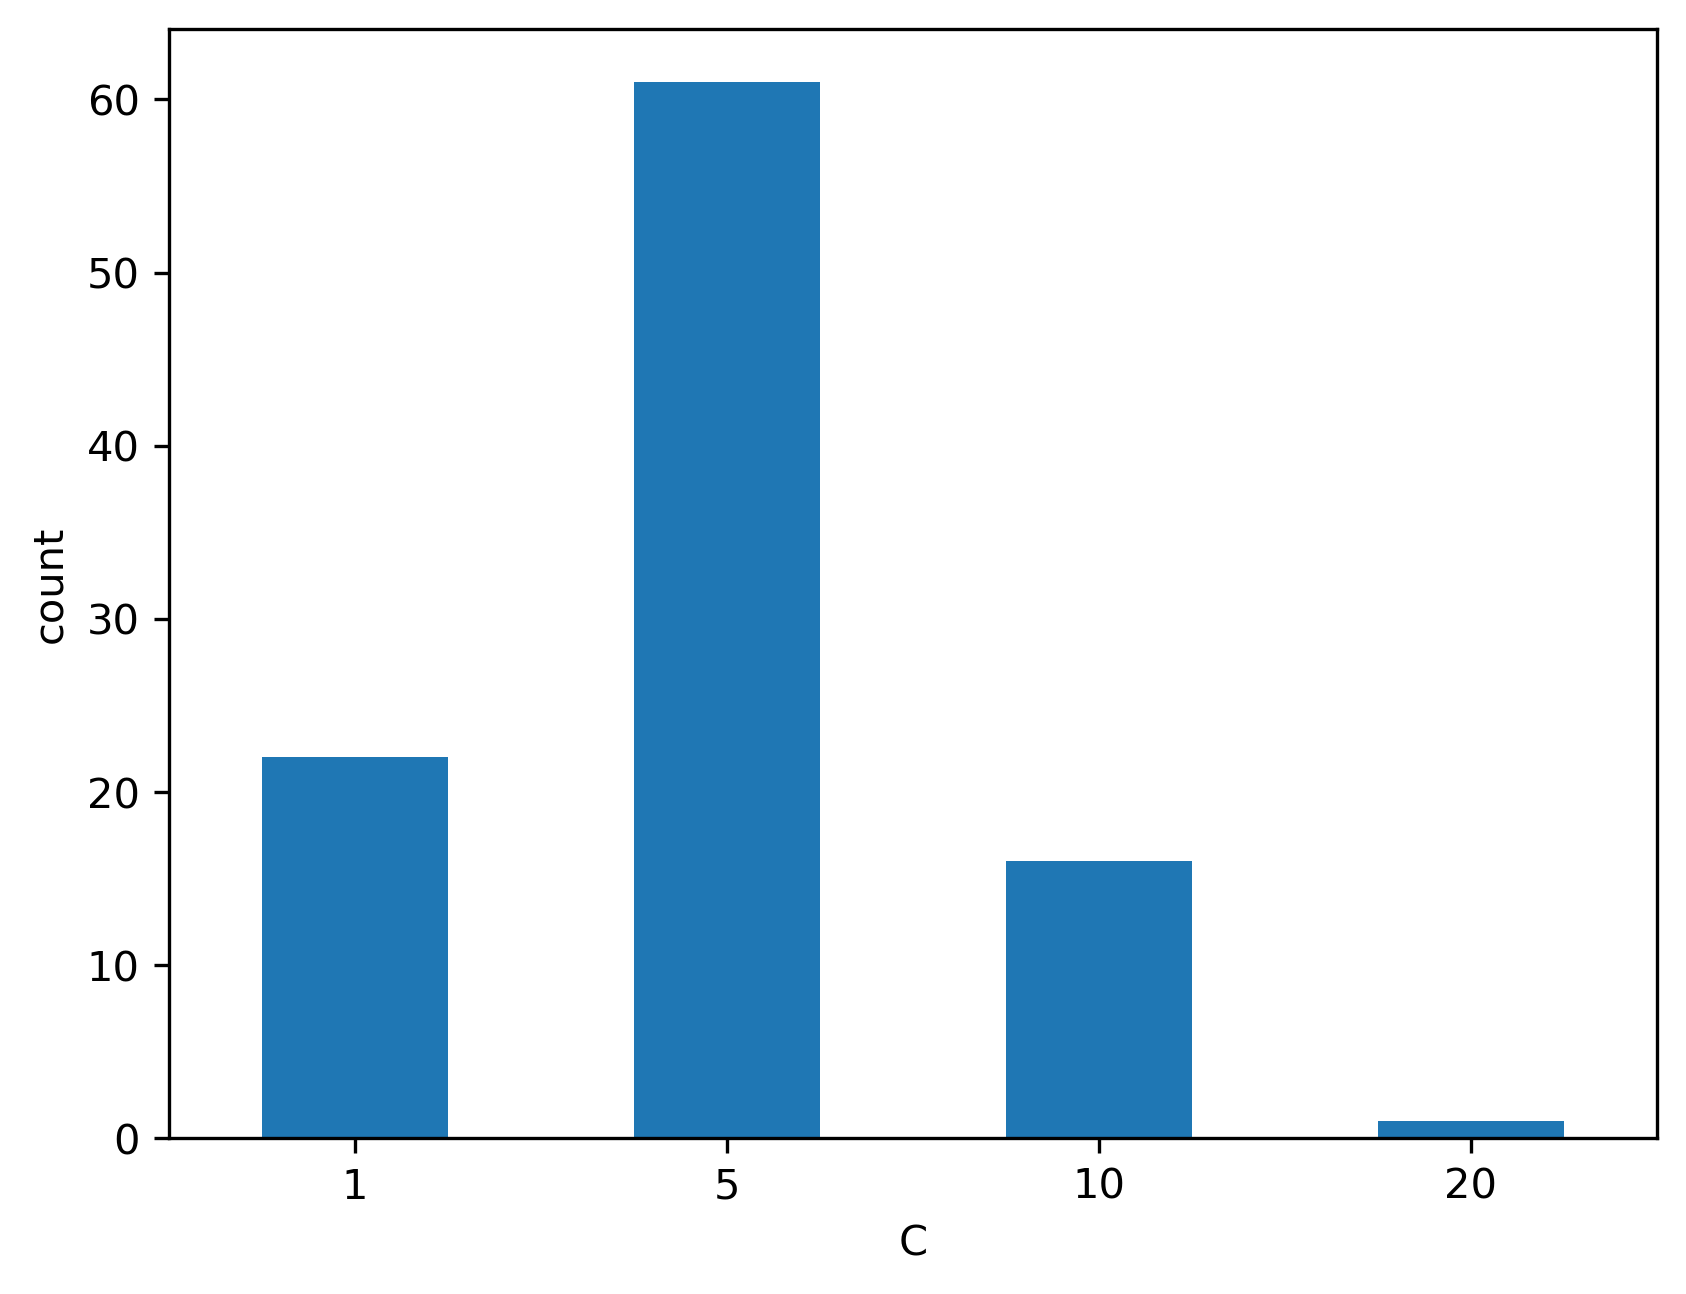

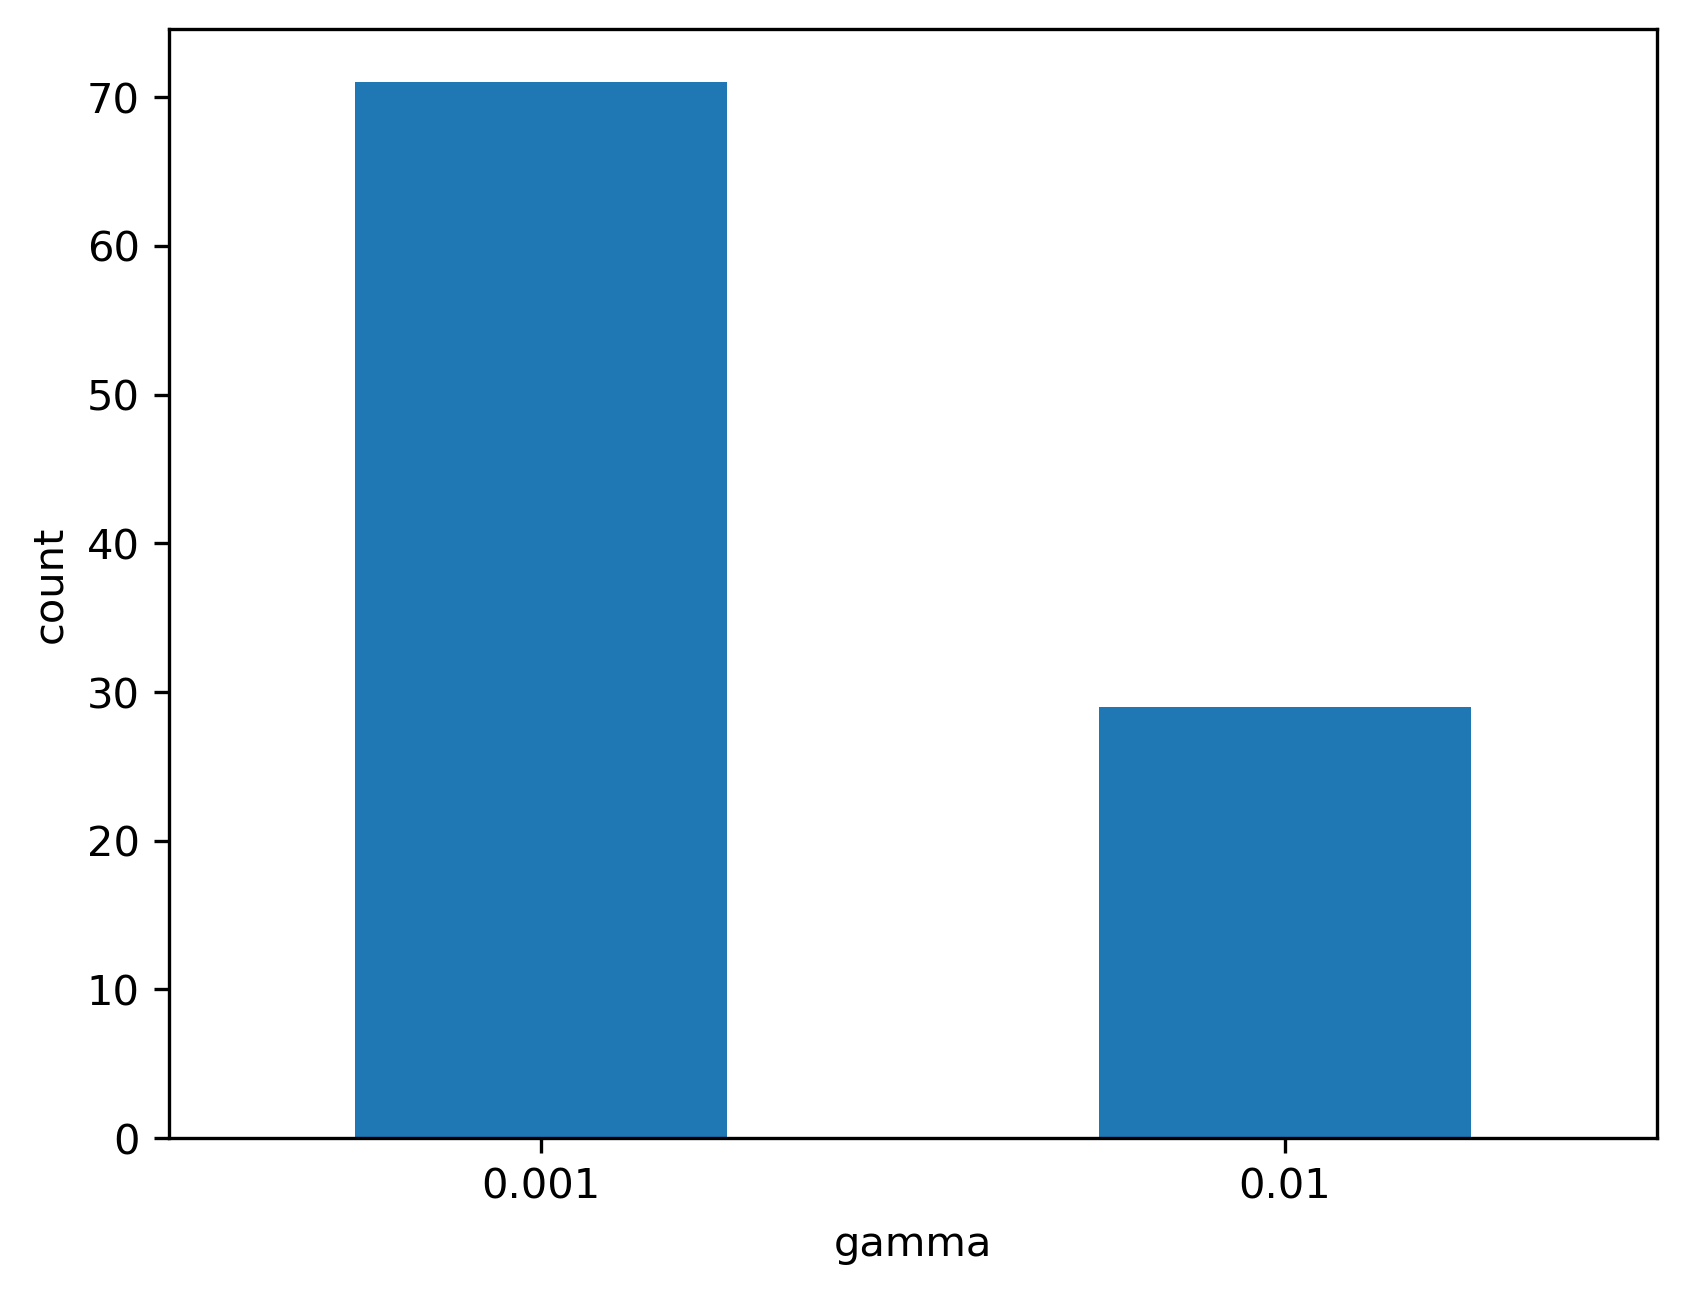

In [11]:
plt.rcParams["figure.dpi"] = 300
for col in stability_param:
    stability_param[col].value_counts().sort_index().plot(kind='bar', rot=0, ylabel='count')
    plt.show()

In [8]:
print('ACC: %.3f (%.3f)' % (mean(acc_svc), std(acc_svc)))
print('Precision: %.3f (%.3f)' % (mean(prec_svc), std(prec_svc)))
print('AuROC: %.3f (%.3f)' % (mean_auc, std_auc))
print('F1: %.3f (%.3f)' % (mean(f1_svc), std(f1_svc)))  
print('AuPRC: %.3f (%.3f)' % (mean_auc_pr, std_auc_pr))

ACC: 0.633 (0.025)
Precision: 0.613 (0.032)
AuROC: 0.663 (0.036)
F1: 0.478 (0.091)
AuPRC: 0.597 (0.037)


# shap analysis

only 5 repetitions (computational too expensive)

In [12]:
np.random.seed(1) # Reproducibility 
CV_repeats = 5
# Make a list of random integers between 0 and 10000 of length = CV_repeats to act as different data splits
random_states = np.random.randint(10000, size=CV_repeats) 

######## Use a dict to track the SHAP values of each observation per CV repitition 

shap_values_per_cv = dict()
for sample in X.index:
    ## Create keys for each sample
    shap_values_per_cv[sample] = {} 
    ## Then, keys for each CV fold within each sample
    for CV_repeat in range(CV_repeats):
        shap_values_per_cv[sample][CV_repeat] = {}
        

In [13]:
patch_sklearn()


param_grid = [{'C': [1, 5,10,20], 
          'gamma': [0.001, 0.01, 1]
              }]

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


precision_array = []
mean_recall_array = np.linspace(0, 1, 100)
aucs_pr=[]

acc_svc=list()
prec_svc=list()
f1_svc=list()
parameters=list()

for i, CV_repeat in enumerate(range(CV_repeats)): #-#-#
    #Verbose 
    print('\n------------ CV Repeat number:', CV_repeat)
    #Establish CV scheme
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_states[i]) # Set random state 

    ix_training, ix_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X,y):
        ix_training.append(fold[0]), ix_test.append(fold[1])
    
    predicted=[]
    label=[]
    score=[]
    
    ## Loop through each outer fold and extract SHAP values 
    for i, (train_outer_ix, test_outer_ix) in enumerate(zip(ix_training, ix_test)): 
        #Verbose
        print('\n------ Fold Number:',i)
        X_train, X_test = X.iloc[train_outer_ix, :], X.iloc[test_outer_ix, :]
        index_train, index_test=X_train.index, X_test.index
        y_train, y_test = y[train_outer_ix], y[test_outer_ix]

        
        #simple imputer
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp_mean.fit(X_train)
        X_train=imp_mean.transform(X_train)
        X_test=imp_mean.transform(X_test)
      
        ## Establish inner CV for parameter optimization #-#-#
        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1) #-#-#
        
        # Search to optimize hyperparameters
        model =SVC(probability=True,random_state=0)
        search = RandomizedSearchCV(model, param_grid, scoring='roc_auc', cv=cv_inner, refit=True,random_state=0) #-#-#
        result = search.fit(X_train, y_train) #-#=#
        
        best_model=result.best_estimator_
        best_param=result.best_params_
        parameters.append(best_param)
        print('Best parameters of the model are: ',best_param)
        
        # Fit model on training data 
        best_model.fit(X_train, y_train) #-#-#
                
        yhat = best_model.predict(X_test)
        
        y_score = best_model.predict_proba(X_test)[:, 1]
        
        label.append(y_test)
        
        predicted.append(yhat)
        score.append(y_score)
        
        
        # explain all the predictions in the test set
        X_train_summary = shap.sample(X_train, 100)
        explainer = shap.KernelExplainer(best_model.predict_proba, X_train_summary)
        shap_values = explainer.shap_values(X_test)[1]        
        
        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(X.index[test_outer_ix]):
            shap_values_per_cv[test_index][CV_repeat] = shap_values[i] #-#-#
        
        
    acc_sc=accuracy_score(np.hstack(label), np.hstack(predicted))
    acc_svc.append(acc_sc)
    #print('Accuracy:',round(acc,4))


    prec_sc=precision_score(np.hstack(label), np.hstack(predicted),pos_label=1)
    prec_svc.append(prec_sc)
    #print('Precision:',round(prec,4))

    
    
    f1_sc=f1_score(np.hstack(label), np.hstack(predicted))
    f1_svc.append(f1_sc)
      

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)



------------ CV Repeat number: 0

------ Fold Number: 0
Best parameters of the model are:  {'gamma': 0.001, 'C': 10}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 1
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 2
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 3
Best parameters of the model are:  {'gamma': 0.001, 'C': 10}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 4
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/88 [00:00<?, ?it/s]


------------ CV Repeat number: 1

------ Fold Number: 0
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 1
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 2
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 3
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 4
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/88 [00:00<?, ?it/s]


------------ CV Repeat number: 2

------ Fold Number: 0
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 1
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 2
Best parameters of the model are:  {'gamma': 0.001, 'C': 10}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 3
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 4
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/88 [00:00<?, ?it/s]


------------ CV Repeat number: 3

------ Fold Number: 0
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 1
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 2
Best parameters of the model are:  {'gamma': 0.01, 'C': 1}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 3
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 4
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/88 [00:00<?, ?it/s]


------------ CV Repeat number: 4

------ Fold Number: 0
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 1
Best parameters of the model are:  {'gamma': 0.001, 'C': 10}


  0%|          | 0/89 [00:00<?, ?it/s]


------ Fold Number: 2
Best parameters of the model are:  {'gamma': 0.001, 'C': 5}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 3
Best parameters of the model are:  {'gamma': 0.001, 'C': 10}


  0%|          | 0/88 [00:00<?, ?it/s]


------ Fold Number: 4
Best parameters of the model are:  {'gamma': 0.01, 'C': 5}


  0%|          | 0/88 [00:00<?, ?it/s]

In [14]:
# Establish lists to keep average Shap values, their Stds, and their min and max
average_shap_values, stds, ranges = [],[],[]

for i in X.index:
    df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
    # Get relevant statistics for every sample 
    average_shap_values.append(df_per_obs.mean(axis=1).values) 
    stds.append(df_per_obs.std(axis=1).values)
    ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

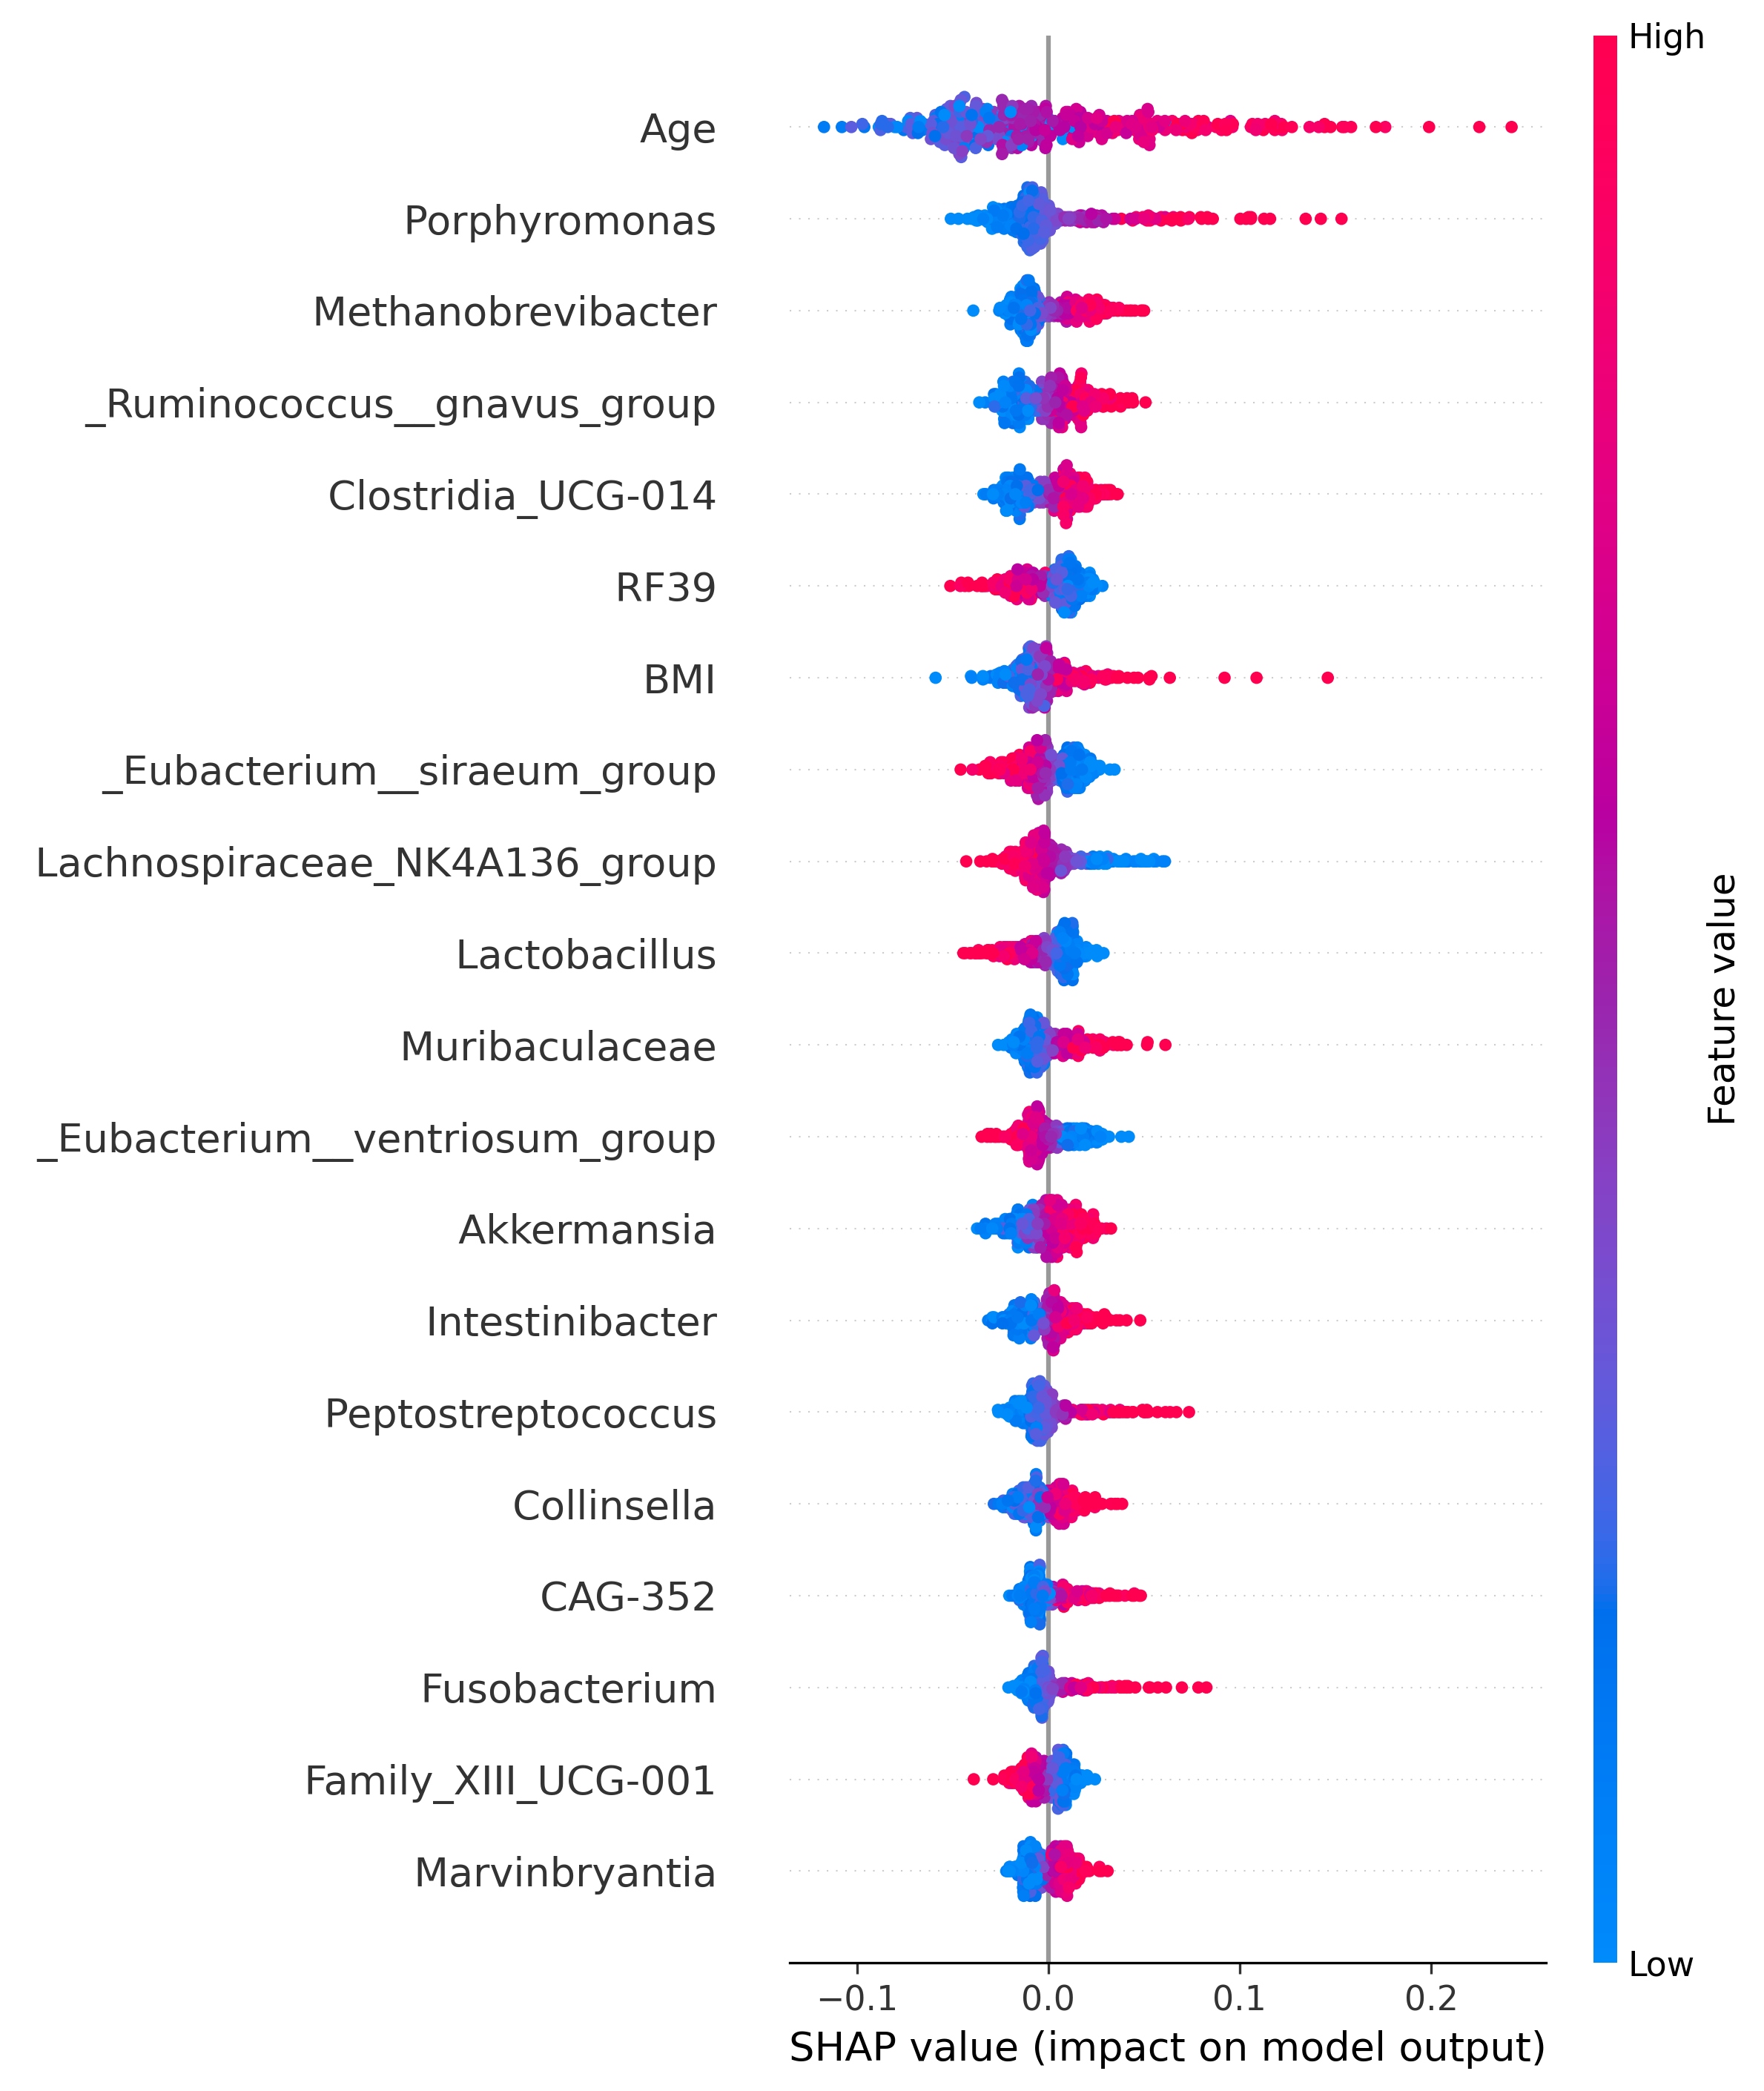

In [15]:
plt.figure(dpi=300)
shap.summary_plot(np.array(average_shap_values), X,max_display=20)

In [16]:
vals= np.abs(np.array(average_shap_values)).mean(0)
shap_feature_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name','feature_importance_vals'])
shap_feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
shap_feature_importance=shap_feature_importance.head(20)
shap_feature=shap_feature_importance['col_name'].values

In [17]:
np.savetxt('shap_feature_svm.txt', shap_feature, fmt='%s')